In [1]:
import argparse
from pathlib import Path

import numpy as np

from super_gradients.training import models
from super_gradients.training.transforms.utils import _rescale_and_pad_to_size, _rescale_xyxy_bboxes

from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

The console stream is logged into /home/marianna.parzych/sg_logs/console.log


[2024-02-02 15:49:10] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-02-02 15:49:10] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-02-02 15:49:19] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-02-02 15:49:19] WARNING - export.py - Failed to import pytorch_quantization
[2024-02-02 15:49:19] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
def box_iou_calc(boxes1, boxes2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        boxes1 (Array[N, 4])
        boxes2 (Array[M, 4])
    Returns:
        iou (Array[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2

    This implementation is taken from the above link and changed so that it only uses numpy..
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(boxes1.T)
    area2 = box_area(boxes2.T)

    lt = np.maximum(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    inter = np.prod(np.clip(rb - lt, a_min=0, a_max=None), 2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

In [ ]:
# DOI: 10.5281/zenodo.3724203

In [3]:
class ConfusionMatrix:
    def __init__(self, num_classes: int, CONF_THRESHOLD=0.3, IOU_THRESHOLD=0.5):
        self.matrix = np.zeros((num_classes + 1, num_classes + 1))
        self.num_classes = num_classes
        self.CONF_THRESHOLD = CONF_THRESHOLD
        self.IOU_THRESHOLD = IOU_THRESHOLD

    def process_batch(self, detections, labels: np.ndarray):
        """
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            detections (Array[N, 6]), x1, y1, x2, y2, conf, class
            labels (Array[M, 5]), class, x1, y1, x2, y2
        Returns:
            None, updates confusion matrix accordingly
        """
        gt_classes = labels[:, 0].astype(np.int16)

        try:
            detections = detections[detections[:, 4] > self.CONF_THRESHOLD]
        except IndexError or TypeError:
            # detections are empty, end of process
            for i, label in enumerate(labels):
                gt_class = gt_classes[i]
                self.matrix[self.num_classes, gt_class] += 1
            return

        detection_classes = detections[:, 5].astype(np.int16)

        all_ious = box_iou_calc(labels[:, 1:], detections[:, :4])
        want_idx = np.where(all_ious > self.IOU_THRESHOLD)

        all_matches = [[want_idx[0][i], want_idx[1][i], all_ious[want_idx[0][i], want_idx[1][i]]]
                       for i in range(want_idx[0].shape[0])]

        all_matches = np.array(all_matches)
        if all_matches.shape[0] > 0:  # if there is match
            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 1], return_index=True)[1]]

            all_matches = all_matches[all_matches[:, 2].argsort()[::-1]]

            all_matches = all_matches[np.unique(all_matches[:, 0], return_index=True)[1]]

        for i, label in enumerate(labels):
            gt_class = gt_classes[i]
            if all_matches.shape[0] > 0 and all_matches[all_matches[:, 0] == i].shape[0] == 1:
                detection_class = detection_classes[int(all_matches[all_matches[:, 0] == i, 1][0])]
                self.matrix[detection_class, gt_class] += 1
            else:
                self.matrix[self.num_classes, gt_class] += 1

        for i, detection in enumerate(detections):
            if not all_matches.shape[0] or ( all_matches.shape[0] and all_matches[all_matches[:, 1] == i].shape[0] == 0 ):
                detection_class = detection_classes[i]
                self.matrix[detection_class, self.num_classes] += 1

    def return_matrix(self):
        return self.matrix

    def print_matrix(self):
        for i in range(self.num_classes + 1):
            print(' '.join(map(str, self.matrix[i])))
            
    def plot_and_save_confusion_matrix(self, class_names, figsize=(8, 8), save_path=None, remove=None, cmap="Blues"):
        matrix = np.array(self.return_matrix()).astype(int)

        if remove:
            rows_to_keep = np.ones(matrix.shape[0], dtype=bool)
            cols_to_keep = np.ones(matrix.shape[1], dtype=bool)
            
            rows_to_keep[indexes_of_classes_to_remove] = False
            cols_to_keep[indexes_of_classes_to_remove] = False
            
            # Use boolean indexing to select only the rows and columns to keep
            matrix = matrix[rows_to_keep][:, cols_to_keep]

        
        plt.figure(figsize=figsize)

        sns.set(font_scale=1.2)
        sns.heatmap(matrix, annot=True, fmt="d", cmap=cmap, xticklabels=class_names, yticklabels=class_names)

        plt.title("Confusion Matrix")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        print("Bottom row: false negatives")
        print("Rights coloms: false positives")

        if save_path:
            plt.savefig(save_path, bbox_inches="tight")
            print(f"Confusion matrix saved to: {save_path}")
        plt.show()

In [4]:
model_type = "yolox_l"
num_classes = 17
checkpoint_path = "path/to/ckpt_best.pth"
data_dir = "/path/to/data/dir/"
images_dir = "all_images"
split_info_pth = "COCO/test.json"
res = 512

In [5]:
model = models.get(model_type, num_classes=num_classes, checkpoint_path=checkpoint_path)

/home/marianna.parzych/Unstructured/super-gradients-fork/src/super_gradients/common/deprecate.py:168: DeprecationWarning: Parameter `arch_params.channels_in` is deprecated since version `3.3.0` and will be removed in version `4.0.0`.
Please update your code to use the `arch_params.in_channels` instead of `arch_params.channels_in`.
  warnings.warn(message, DeprecationWarning)
[2024-02-02 15:49:21] INFO - checkpoint_utils.py - Successfully loaded model weights from /mnt/ml-team/homes/marianna.parzych/Unstructured/super-gradients-fork/checkpoints/training_new_data_from_doclaynet/RUN_20240129_122033_849622/ckpt_best.pth EMA checkpoint.


In [6]:
dataset = COCOFormatDetectionDataset(
    data_dir=data_dir,
    json_annotation_file=split_info_pth,
    images_dir=images_dir,
)

loading annotations into memory...


[2024-02-02 15:49:21] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


Done (t=0.21s)
creating index...
index created!


Indexing dataset annotations: 100%|█| 462/462 [00:00<00:00, 1248.49it


In [19]:
all_predictions = []
all_annos = []

In [20]:
iou_thresh = 0.65
conf_thresh = 0.01
conf_mat = ConfusionMatrix(num_classes = num_classes, CONF_THRESHOLD = conf_thresh, IOU_THRESHOLD = iou_thresh)
# remove above
for image, target, _ in dataset:

    gt_bboxes = target[:,:4]
    gt_labels = target[:,-1]
        
    if res:
        image_input, r = _rescale_and_pad_to_size(image, (res, res))
    else:
        image_input = image
        r = None

    output = model.predict(image_input, iou=0.65, conf=0.01)
    
    bboxes = output.prediction.bboxes_xyxy
    labels = output.prediction.labels
    scores = output.prediction.confidence
    if r:
        bboxes = _rescale_xyxy_bboxes(bboxes, 1 / r) 
    
    prediction = np.c_[bboxes, scores, labels]
    all_predictions.append(prediction)
    
    annos = np.c_[gt_labels, gt_bboxes]
    all_annos.append(annos)

    conf_mat.process_batch(prediction, annos)  # remove

[2024-02-02 15:53:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-02 15:53:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-02 15:53:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-02 15:53:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-02 15:53:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-02 15:53:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-02 15:53:20] INFO -

In [21]:
# np.save("predictions.npy", all_predictions, allow_pickle=True, fix_imports=True)
# np.save("annos.npy", all_annos, allow_pickle=True, fix_imports=True)

In [22]:
# all_predictions = np.load("predictions.npy", allow_pickle=True, fix_imports=True)
# all_annos = np.load("annos.npy", allow_pickle=True, fix_imports=True)

In [23]:
class_names = ["image", "page_number", "paraprgaphs_in_image", "paraprgaph", "subheading", "page_header", "formulas", "other", "table", "page_footer", "title", "form", "paraprgaphs_in_form", "checkbox_checked", "checkbox", "radio_button", "radio_button_checked"]

### Confusion matrix

Bottom row: false negatives
Rights coloms: false positives


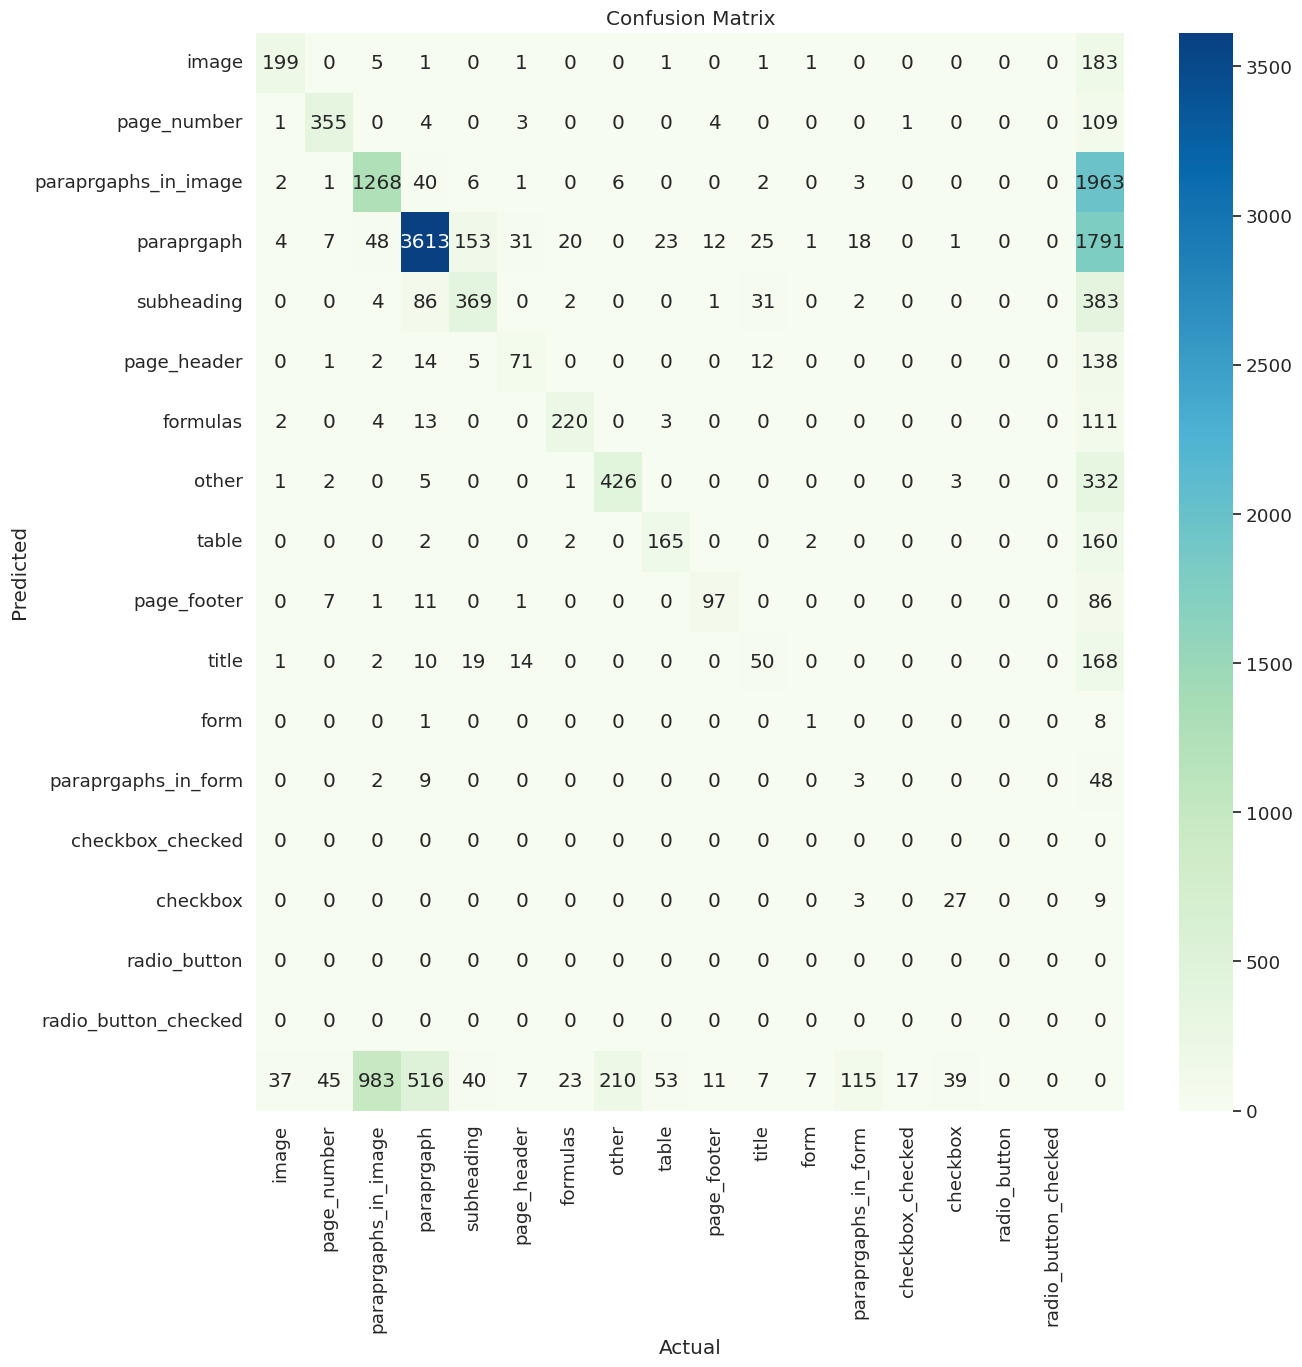

The most numerous classes (paragraph, paragraph_in_image, subheding, image, page_number) are often identified correctly 
There are many false positives, because of low confidence score. This can be addressed with tuning confidence thresholds for each class separatelly
There are many false negatives - most probably many of them are caused by the non-consistentency between ground truth and predictions, eg. part of text annotated as single paragraph detected as 2 paragraphs because on preffix space.


In [24]:
iou_thresh = 0.65
conf_thresh = 0.1
conf_mat = ConfusionMatrix(num_classes = num_classes, CONF_THRESHOLD = conf_thresh, IOU_THRESHOLD = iou_thresh)
for prediction, annos in zip(all_predictions, all_annos):
    conf_mat.process_batch(prediction, annos)
conf_mat.plot_and_save_confusion_matrix(class_names, figsize=(14, 14), cmap="GnBu")
print("The most numerous classes (paragraph, paragraph_in_image, subheding, image, page_number) are often identified correctly ")
print("There are many false positives, because of low confidence score. This can be addressed with tuning confidence thresholds for each class separatelly")
print("There are many false negatives - most probably many of them are caused by the non-consistentency between ground truth and predictions, eg. part of text annotated as single paragraph detected as 2 paragraphs because on preffix space.")


### Lowering the iou threshhold to decrease number of false netagives

Bottom row: false negatives
Rights coloms: false positives


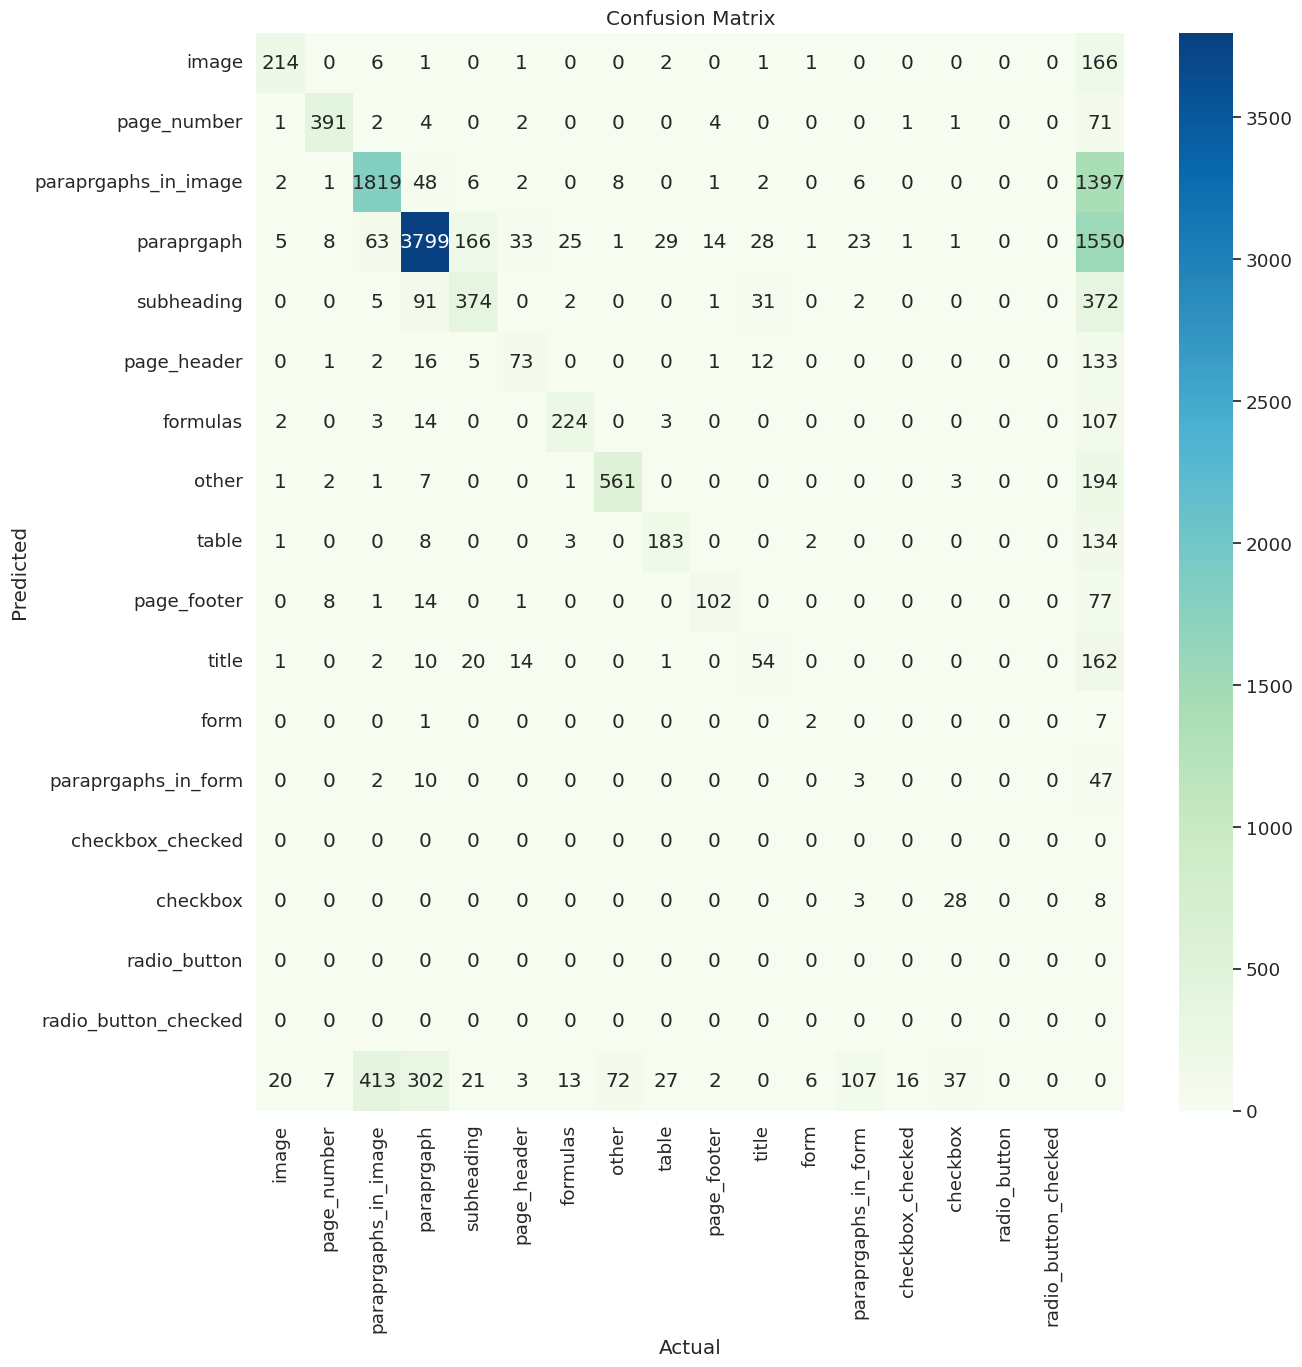

After lowering the iou threshold for detection-prediction matching, the number of false netagives decreased.
Providing more consistency in class labeling should ensure better results in the future


In [25]:

iou_thresh = 0.3
conf_thresh = 0.1
conf_mat = ConfusionMatrix(num_classes = num_classes, CONF_THRESHOLD = conf_thresh, IOU_THRESHOLD = iou_thresh)
for prediction, annos in zip(all_predictions, all_annos):
    conf_mat.process_batch(prediction, annos)
conf_mat.plot_and_save_confusion_matrix(class_names, figsize=(14, 14), cmap="GnBu")
print("After lowering the iou threshold for detection-prediction matching, the number of false netagives decreased.")
print("Providing more consistency in class labeling should ensure better results in the future")

### Removing classes that are under represented from analysis

Bottom row: false negatives
Rights coloms: false positives


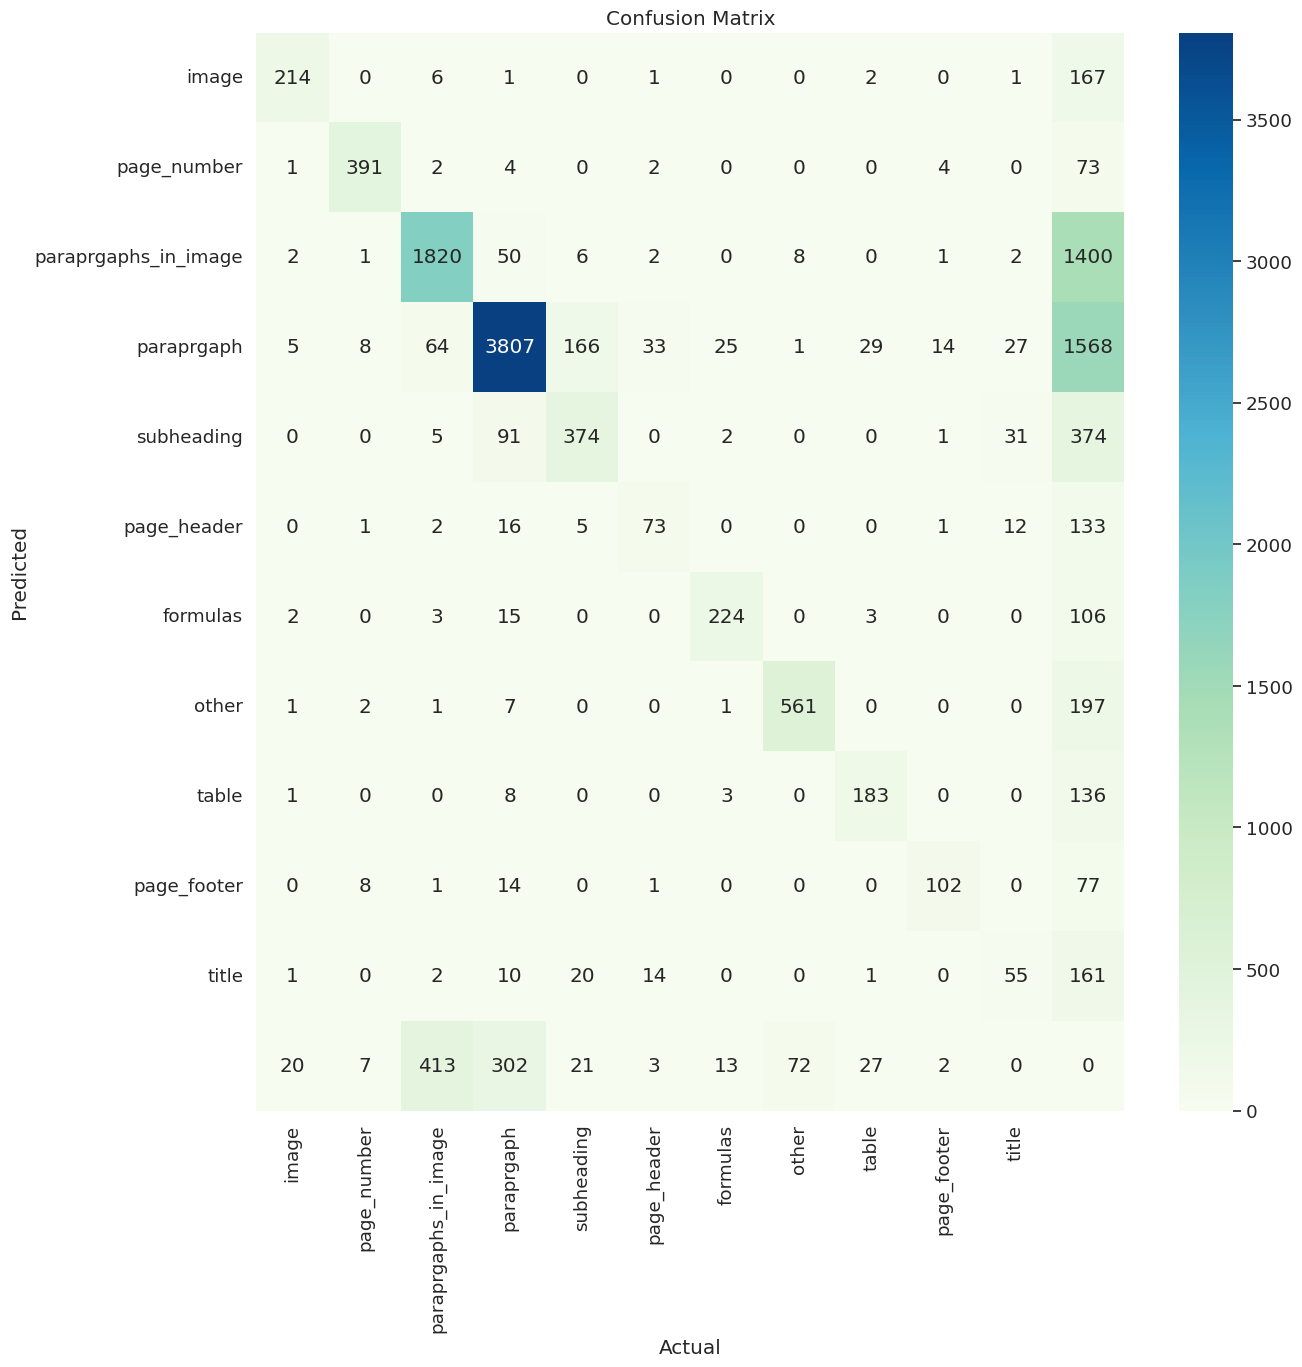

In [26]:


iou_thresh = 0.3
conf_thresh = 0.1

classes_to_remove = ["form", "paraprgaphs_in_form", "checkbox_checked", "checkbox", "radio_button", "radio_button_checked"]
new_class_names = [value for value in class_names if value not in classes_to_remove]

conf_mat = ConfusionMatrix(num_classes = num_classes, CONF_THRESHOLD = conf_thresh, IOU_THRESHOLD = iou_thresh)
for prediction, annos in zip(all_predictions, all_annos):
    new_prediction = prediction[:]
    new_annos = annos[:]

    indexes_of_classes_to_remove = [class_names.index(name) for name in classes_to_remove]

    for value_to_remove in indexes_of_classes_to_remove:
        rows_to_keep = new_prediction[:, -1] != value_to_remove
        new_prediction = new_prediction[rows_to_keep]
    
        rows_to_keep = new_annos[:, 0] != value_to_remove
        new_annos = new_annos[rows_to_keep]
    
    conf_mat.process_batch(new_prediction, new_annos)
conf_mat.plot_and_save_confusion_matrix(new_class_names, figsize=(14, 14), remove=indexes_of_classes_to_remove, cmap="GnBu")

### Merging similar classes: paragraph, paragraph_in_form

Bottom row: false negatives
Rights coloms: false positives


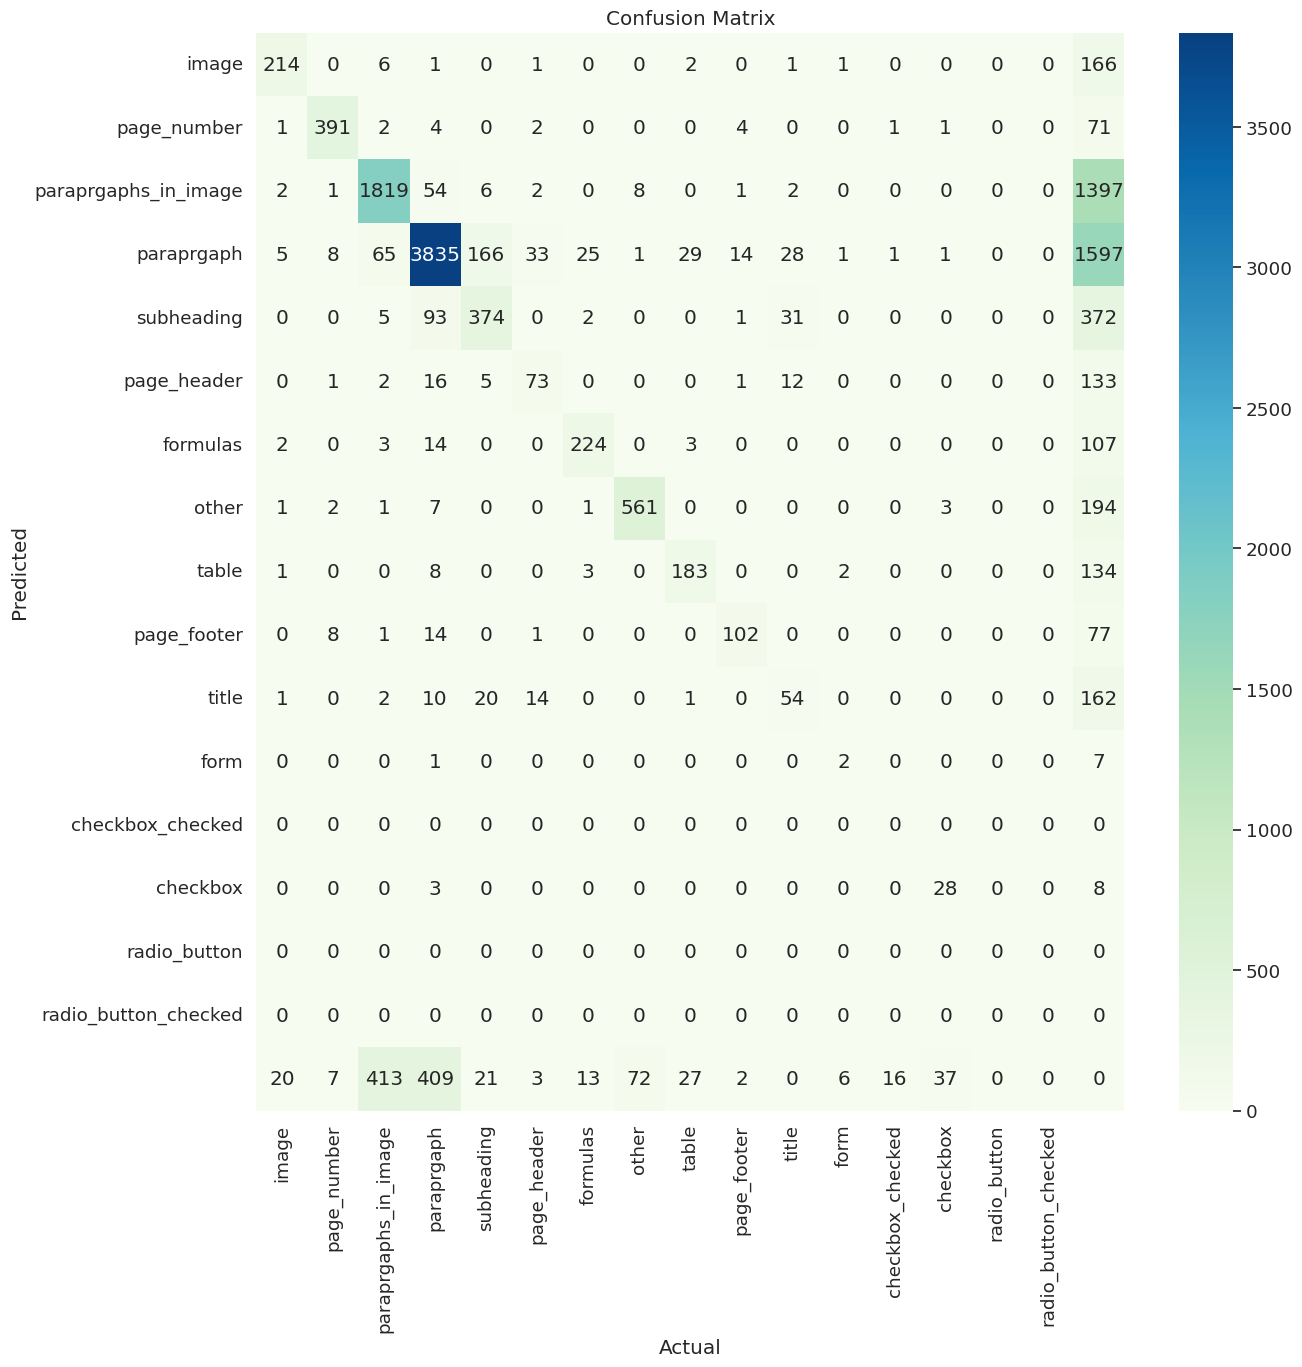

Merging paragraph_in_form and paragraph_in_image and paragraph doesnt help - it only make the results of the paragraph worse
This means  it is not a big problem with confusing them, it is much more the problem with undetected paragraphs_in_images and paragraphs_in_form


In [27]:
iou_thresh = 0.3
conf_thresh = 0.1
classes_to_merge = {
    "paraprgaph": ["paraprgaph", "paraprgaphs_in_form"],
    
}
all_values = [value for values_list in classes_to_merge.values() for value in values_list]
all_keys = list(classes_to_merge.keys())
classes_to_remove = list(set(all_values) - set(all_keys))

new_class_names = [value for value in class_names if value not in classes_to_remove]

conf_mat = ConfusionMatrix(num_classes = num_classes, CONF_THRESHOLD = conf_thresh, IOU_THRESHOLD = iou_thresh)
for prediction, annos in zip(all_predictions, all_annos):
    new_prediction = prediction[:]
    new_annos = annos[:]
    
    for main_class_name in classes_to_merge:
        index_of_main_class = class_names.index(main_class_name)
        indexes_of_classes_to_merge = [class_names.index(name) for name in classes_to_merge[main_class_name]]
        indexes_of_classes_to_remove = [class_names.index(name) for name in classes_to_remove]

        update_condition = np.isin(new_prediction[:, -1], indexes_of_classes_to_merge)
        new_prediction[update_condition, -1] = index_of_main_class

        update_condition = np.isin(new_annos[:, 0], indexes_of_classes_to_merge)
        new_annos[update_condition, 0] = index_of_main_class
    
    conf_mat.process_batch(new_prediction, new_annos)
conf_mat.plot_and_save_confusion_matrix(new_class_names, figsize=(14, 14), remove=indexes_of_classes_to_remove, cmap="GnBu")
print("Merging paragraph_in_form and paragraph_in_image and paragraph doesnt help - it only make the results of the paragraph worse")
print("This means  it is not a big problem with confusing them, it is much more the problem with undetected paragraphs_in_images and paragraphs_in_form")

Bottom row: false negatives
Rights coloms: false positives


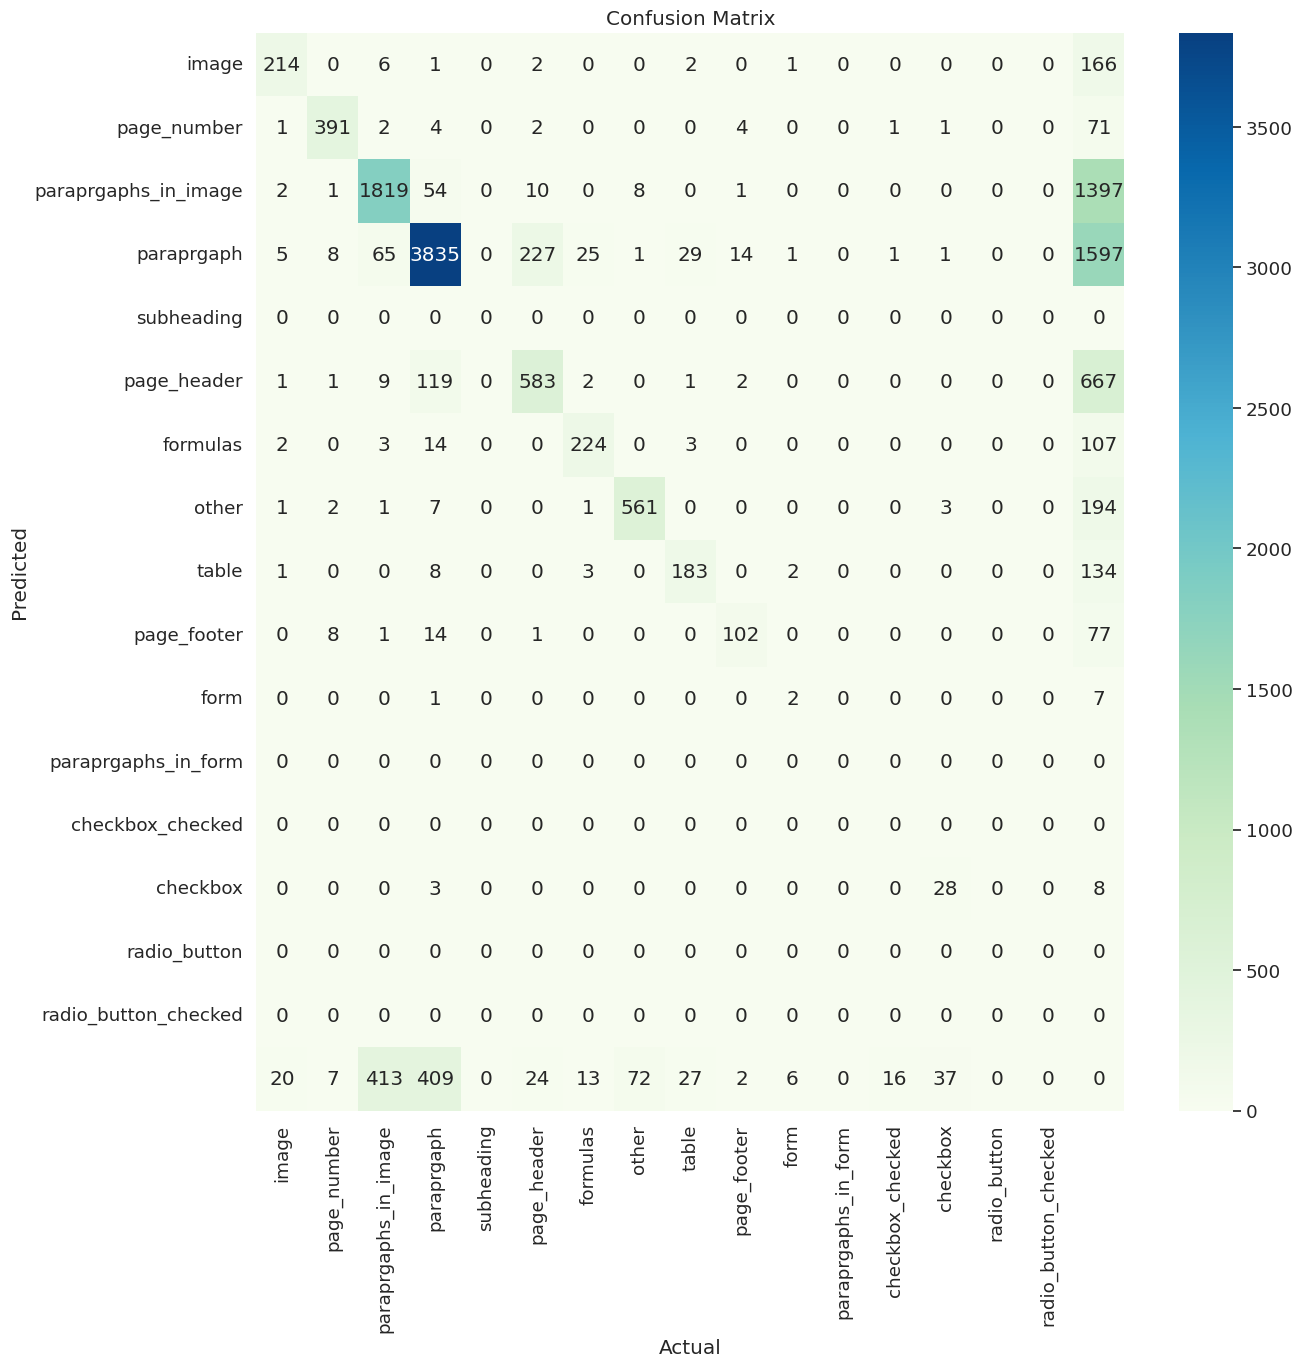

In [29]:
iou_thresh = 0.3
conf_thresh = 0.1
classes_to_merge = {
    "page_header": ["page_header", "title"],
}
all_values = [value for values_list in classes_to_merge.values() for value in values_list]
all_keys = list(classes_to_merge.keys())
classes_to_remove = list(set(all_values) - set(all_keys))

new_class_names = [value for value in class_names if value not in classes_to_remove]

conf_mat = ConfusionMatrix(num_classes = num_classes, CONF_THRESHOLD = conf_thresh, IOU_THRESHOLD = iou_thresh)
for prediction, annos in zip(all_predictions, all_annos):
    new_prediction = prediction[:]
    new_annos = annos[:]
    
    for main_class_name in classes_to_merge:
        index_of_main_class = class_names.index(main_class_name)
        indexes_of_classes_to_merge = [class_names.index(name) for name in classes_to_merge[main_class_name]]
        indexes_of_classes_to_remove = [class_names.index(name) for name in classes_to_remove]

        update_condition = np.isin(new_prediction[:, -1], indexes_of_classes_to_merge)
        new_prediction[update_condition, -1] = index_of_main_class

        update_condition = np.isin(new_annos[:, 0], indexes_of_classes_to_merge)
        new_annos[update_condition, 0] = index_of_main_class
    
    conf_mat.process_batch(new_prediction, new_annos)
conf_mat.plot_and_save_confusion_matrix(new_class_names, figsize=(14, 14), remove=indexes_of_classes_to_remove, cmap="GnBu")